In [1]:
# from sagemaker.tensorflow import TensorFlow
import tensorflow as tf
import numpy as np
import pandas as pd
import tensorflow.keras as keras
import matplotlib.pyplot as plt
%matplotlib inline

2024-06-11 08:14:36.747260: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: SSE4.1 SSE4.2 AVX AVX2 AVX512F FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [2]:
IMAGE_SIZE=256
BATCH_SIZE=32
CHANNELS=3
EPOCHS=50

In [3]:
dataset=tf.keras.preprocessing.image_dataset_from_directory(
    'PlantVillage',
    shuffle=True,
    image_size=(IMAGE_SIZE,IMAGE_SIZE),
    batch_size=BATCH_SIZE
)

Found 2152 files belonging to 3 classes.


In [4]:
class_names=dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
len(dataset)

68

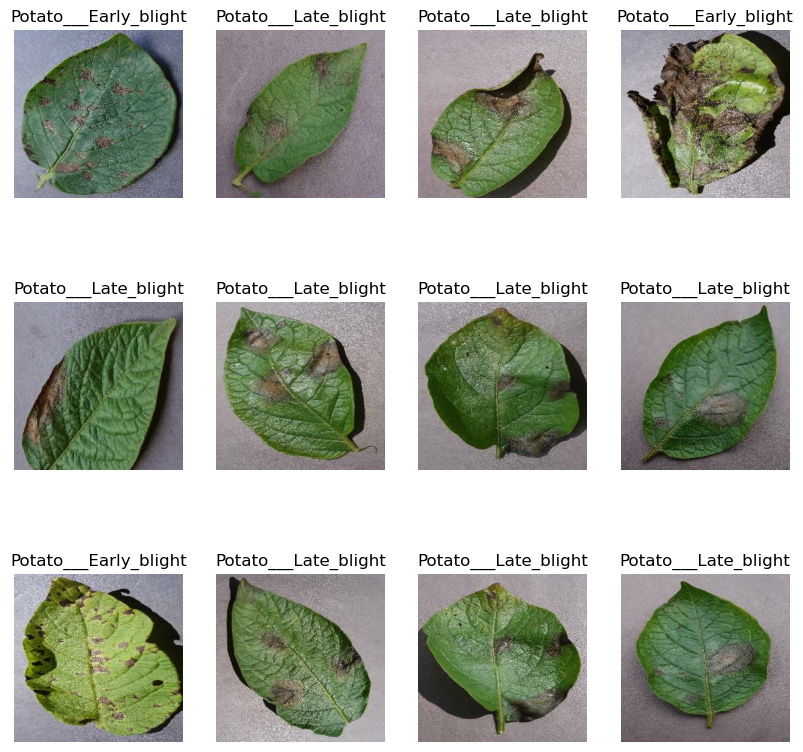

In [6]:
plt.figure(figsize=(10,10))
for image_batch,label_batch in dataset.take(1):
    for i in range(12):
        ax=plt.subplot(3,4,i+1)
        plt.imshow(image_batch[i].numpy().astype('uint8'))
        plt.title(class_names[label_batch[i]])
        plt.axis('off')
 

In [7]:
train_ds=dataset.take(54)
len(train_ds)

54

In [8]:
test_ds=dataset.skip(54)
len(test_ds)

14

In [9]:
val_ds=test_ds.take(6)
test_ds=test_ds.skip(6)
len(val_ds),len(test_ds)

(6, 8)

In [10]:
def get_dataset_partitions_tf(ds,train_split=0.8,val_split=0.1,test_size=0.1,shuffle=True,shuffle_size=10000):

    ds_size=len(ds)
    if shuffle:
        ds.shuffle(shuffle_size,seed=12)
    train_size=int(train_split*ds_size)
    val_size=int(val_split*ds_size)
    
    train_ds=ds.take(train_size)
    
    val_ds=ds.skip(train_size).take(val_size)
    test_ds=ds.skip(train_size).skip(val_size)
    
    return train_ds,val_ds,test_ds

In [11]:
train_ds,val_ds,test_ds=get_dataset_partitions_tf(dataset)

In [12]:
len(train_ds),len(val_ds),len(test_ds)

(54, 6, 8)

In [13]:
train_ds=train_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_ds=val_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_ds=test_ds.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)


In [14]:
from keras import layers

In [15]:
resizeing_rescaling = keras.Sequential([
    layers.Resizing(IMAGE_SIZE,IMAGE_SIZE),
    layers.Rescaling(1.0/255),
])

In [16]:
data_augmentation=keras.Sequential([
    layers.RandomFlip("horizontal_and_vertical"),
    layers.RandomRotation(0.2),
])

In [17]:
input_shape = (BATCH_SIZE,IMAGE_SIZE,IMAGE_SIZE,CHANNELS)
num_classes =3
model = keras.Sequential([
    resizeing_rescaling,
    data_augmentation,

    layers.Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),
    
    layers.Conv2D(filters=64,kernel_size=(3,3),activation='relu'),
    layers.MaxPooling2D((2,2)),

    layers.Flatten(),
    layers.Dense(64,activation='relu'),
    layers.Dense(num_classes , activation='softmax')
])

model.build(input_shape=input_shape)


In [18]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2  (32, 127, 127, 32)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPoolin  (32, 62, 62, 64)          0         
 g2D)                                                 

In [19]:
model.compile(
    optimizer='adam',
    loss=keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy']
)

In [20]:
history=model.fit(
    train_ds,
    epochs=EPOCHS,
    batch_size=BATCH_SIZE,
    verbose=1,
    validation_data=val_ds,
)

Epoch 1/50
54/54 [==============================] - 109s 2s/step - loss: 0.8568 - accuracy: 0.5469 - val_loss: 0.9335 - val_accuracy: 0.5625
Epoch 2/50
54/54 [==============================] - 104s 2s/step - loss: 0.6010 - accuracy: 0.7228 - val_loss: 0.5958 - val_accuracy: 0.7344
Epoch 3/50
54/54 [==============================] - 106s 2s/step - loss: 0.4244 - accuracy: 0.8345 - val_loss: 0.4809 - val_accuracy: 0.8177
Epoch 4/50
54/54 [==============================] - 104s 2s/step - loss: 0.3037 - accuracy: 0.8831 - val_loss: 0.2187 - val_accuracy: 0.9115
Epoch 5/50
54/54 [==============================] - 106s 2s/step - loss: 0.2327 - accuracy: 0.9091 - val_loss: 0.2739 - val_accuracy: 0.8750
Epoch 6/50
54/54 [==============================] - 104s 2s/step - loss: 0.2063 - accuracy: 0.9190 - val_loss: 0.1608 - val_accuracy: 0.9479
Epoch 7/50
54/54 [==============================] - 105s 2s/step - loss: 0.1494 - accuracy: 0.9421 - val_loss: 0.5240 - val_accuracy: 0.7552
Epoch 8/50
54

In [21]:
model.evaluate(test_ds)

8/8 [==============================] - 5s 435ms/step - loss: 0.0566 - accuracy: 0.9655


[0.05664539337158203, 0.9655172228813171]